# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

<Figure size 432x288 with 0 Axes>

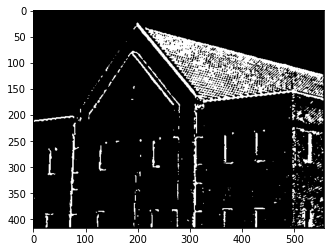

In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

dom = cv2.imread("dom.png")
dom = cv2.cvtColor(dom,cv2.COLOR_BGR2GRAY)

def crossing(LoG: np.ndarray, thr):
    x_size, y_size = LoG.shape
    output = np.zeros((x_size,y_size))
    for x in range(1, x_size-1):
        for y in range(1,y_size-1):
            seround = LoG[x-1:x+2,y-1:y+2]
            min_s = np.min(seround)
            max_s = np.max(seround)
            if np.sign(max_s) != np.sign(min_s):
                pix = seround[1,1]
                output[x,y] = pix + abs(min_s) if pix > 0 else abs(pix) + max_s
    output = output/np.max(output)*255
    output = output > thr
    output = np.uint8(output)
    output *= 255
    output = np.uint8(output)
    output = cv2.medianBlur(output,3)
    return output

thr = 80
sigm = 0.1
# for thr in range(60,100,10):
#     for sigm in np.arange(0.1,3,0.3):
dom_rozmyty = cv2.GaussianBlur(dom, (3,3), sigm)
dom_lapl = cv2.Laplacian(dom_rozmyty,cv2.CV_32F)
plt.gray()
plt.figure()
plt.imshow(crossing(dom_lapl,thr))





## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

In [6]:
def calc_value(alpha,matrix):
    if -22.5 <= alpha <= 22.5 or -157.5 <= alpha <= 157.5: # poziom
        a,b,c = matrix[1,:]
    elif 22.5 <= alpha <= 67.5 or -157.5 <= alpha <= -112.5: # skos prawy
        a,b,c = matrix[2,0],matrix[1,1],matrix[0,2]
    elif 67.5 <= alpha <= 112.5 or -112.5 <= -67.5: # pion
        a,b,c = matrix[:,1]
    else: # skos lewy
        a,b,c = matrix[0,0],matrix[1,1],matrix[2,2]
    if b == np.max([a,b,c]):
        return b
    else:
        return 0

def canny(dom,ksize,sigma, tl, th):
    dom = cv2.GaussianBlur(dom,(ksize,ksize),sigma)
    sobelx = cv2.Sobel(dom,cv2.CV_32F,1,0)
    sobely = cv2.Sobel(dom,cv2.CV_32F,0,1)
    M = np.sqrt(sobelx**2 + sobely**2)
    alfa = np.arctan2(sobelx,sobely)/np.pi*180
    size_x,size_y = M.shape
    g = np.zeros(M.shape)
    for x in range(1,size_x-1):
        for y in range(1,size_y-1):
            matrix = M[x-1:x+2,y-1:y+2]
            angle = alfa[x,y]
            g[x,y] = calc_value(angle, matrix)
    gh = (g > th) * g
    gl = np.logical_and(th > g,g > tl) * g
    return gl, gh

gl,gh = canny(dom, 3, 0.5,40, 100)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'GaussianBlur' of type Module(<module 'cv2.cv2' from 'c:\\users\\ignsz\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\cv2\\cv2.cp38-win_amd64.pyd'>)
[1m
File "<ipython-input-6-3e65d94f8fb1>", line 19:[0m
[1mdef canny(dom,ksize,sigma, tl, th):
[1m    dom = cv2.GaussianBlur(dom,(ksize,ksize),sigma)
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at <ipython-input-6-3e65d94f8fb1> (19)[0m
[1m
File "<ipython-input-6-3e65d94f8fb1>", line 19:[0m
[1mdef canny(dom,ksize,sigma, tl, th):
[1m    dom = cv2.GaussianBlur(dom,(ksize,ksize),sigma)
[0m    [1m^[0m[0m


In [ ]:
plt.imshow(dom)
plt.figure(figsize=(20,20))
plt.imshow(gl)
plt.figure(figsize=(20,20))
plt.imshow(gh)
"""
łoł. No... To działa czadowo!
"""

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

In [ ]:
result = cv2.Canny(dom,100,230,None,3,1)
plt.figure(figsize=(20,20))
plt.imshow(result)
"""
Pierwsza różnica jest taka że ten pierszy napisałem sam  i w miarę szybko zadziałał wiec zwraca on więcej satysfakcji
W cv2-owym krawędzie zdają się być grubsze.
"""